In [1]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp /content/drive/MyDrive/ECG_Heartbeat_Categorization/Utils/DataUtils/DataImputation.py /content
!cp /content/drive/MyDrive/ECG_Heartbeat_Categorization/Utils/DataUtils/DataLoader.py /content
!cp /content/drive/MyDrive/ECG_Heartbeat_Categorization/Utils/DataUtils/DataProcessing.py /content
!cp /content/drive/MyDrive/ECG_Heartbeat_Categorization/Utils/DataUtils/DataAnalysing.py /content
!cp /content/drive/MyDrive/ECG_Heartbeat_Categorization/DeepLearning/TransformerBasedModel.py /content
!cp /content/drive/MyDrive/ECG_Heartbeat_Categorization/Utils/TrainingUtils.py /content
!cp /content/drive/MyDrive/ECG_Heartbeat_Categorization/Utils/EvaluationUtils.py /content

**Hello. In this notebook, I will explain the steps I have taken for the <mark>training-testing</mark> and the reasoning behind them. I will also provide references that have helped me make decisions and choose these approaches. Thank you for taking the time to review the uploaded files and for providing this opportunity.**

In [3]:
# Importing requred libraries and modules
import numpy as np
from DataImputation import impute_missing_values
from DataLoader import ECGDataLoader
import DataProcessing as data_processing
import DataAnalysing as data_analysing
import TransformerBasedModel as transformer_based_model
from TrainingUtils import train_model, hyperparameter_tuning
from EvaluationUtils import show_learning_curves, create_confusion_matrix, metrics_calculation
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [4]:
# Create an instance of ECGDataLoader
train_data_loader = ECGDataLoader('/content/drive/MyDrive/ECG/mitbih_train.csv')
test_data_loader = ECGDataLoader('/content/drive/MyDrive/ECG/mitbih_test.csv')

# Load the ECG dataset from the CSV file
train_data_loader.load_ecg_dataset_csv()
test_data_loader.load_ecg_dataset_csv()

# Get the dataset
train_data = train_data_loader.get_dataset()
test_data = test_data_loader.get_dataset()


To address the issue of class imbalance in the dataset, data augmentation has been applied to categories 1, 2, 3, and 4, with the factor of 5. The purpose of this augmentation is to create a more balanced dataset, as there is a significant disparity in the number of samples across categories. By augmenting the data in these categories, we aim to ensure a more equitable representation and enhance the model's performance and accuracy for each category.

In [5]:
# Apply imputation to address missing data
train_data = impute_missing_values(train_data, method='forward')
test_data = impute_missing_values(test_data, method='forward')

# # Split the data into train and holdout data
train_data, holdout_data = train_test_split(train_data, test_size=0.1, random_state=42, stratify=train_data.iloc[:, -1])

train_data = data_processing.augment_dataset(train_data, augmentation_factor= 5)
holdout_data = data_processing.add_noise_dataset(holdout_data, level = 0.02)

x_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
x_test, y_test = test_data.iloc[:, :-1].values, test_data.iloc[:, -1].values
x_holdout, y_holdout = holdout_data.iloc[:, :-1].values, holdout_data.iloc[:, -1].values

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
x_holdout = x_holdout.reshape((x_holdout.shape[0], x_holdout.shape[1], 1))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

<mark>Model Selection</mark>

Refernces:

1. [Arrhythmia classification algorithm based on multi-head
self-attention mechanism](https://www.sciencedirect.com/science/article/pii/S1746809422006607)
2. [Timeseries classification with a Transformer model](https://keras.io/examples/timeseries/timeseries_classification_transformer/)
3. [Implemented in Huggingface](https://huggingface.co/keras-io/timeseries_transformer_classification)


The paper cited here provides an example of using multi-head self-attention mechanism for heartbeat classification, which is a challenging task due to the variability and noise in ECG signals. The paper reports that the model achieved 99.4% accuracy, outperforming other baseline models such as LSTM, CNN, and SVM. This shows that attention based models can handle complex and noisy data and provide high-quality classification results. 

Transformer based models are using the attention mechanism, which allows them to capture the long-range dependencies and contextual information in the input data. This can improve the performance and accuracy of the classification task, especially for complex and high-dimensional data.

Transformer based models have been shown to achieve state-of-the-art results in various natural language processing and computer vision tasks, such as machine translation, text summarization, image captioning, and object detection. This demonstrates their versatility and generalizability for different types of classification tasks.

Transformer based model can leverage the existing pre-trained models and fine-tune them for the ECG signal classification task, which can save the training time and data resources.

Transformer based models are known for their complex architecture, making it challenging to interpret the decision-making process.


Based on these points, a transformer based model is a suitable and effective choice for a classification task.

The model utilized in this context is also available in Hugging Face, where it has been pre-trained on different dataset. Users have the flexibility to load and fine-tune these models according to their specific tasks, thereby leveraging the advantages of transfer learning.



<mark>Hyperparameters tuning</mark>


Hyperparameter tuning is an essential step in optimizing machine learning models. It involves finding the best combination of hyperparameters that maximize the performance of a model on a given task. One approach to perform hyperparameter tuning is by using GridSearchCV, which searches through a specified grid of hyperparameters to find the optimal values. A model wrapper function is then created that allows to specify the hyperparameters need to be tuned. The model wrapper function acts as an interface between the scikit-learn's GridSearchCV and the model. The function has been writen in the training utils.

Below, you can see how the hyperparameter_tuning function searches for the more effective learning_rate. 

Some hyperparapeters related to the model's architecture were chosen based on Hugging Face's successful implementation in similar tasks, indicating their effectiveness in capturing complex patterns and improving model performance. 

It is also important to use insights gained from the learning curve analysis. The learning curve provides valuable insights into how the model's performance evolved with different values of these hyperparameters.

Choosing a small learning rate and training for more epochs can improve model convergence, generalization, and robustness to noise. However, it also increases training time and the risk of overfitting. Proper hyperparameter tuning, regularization techniques and monitoring the training process are crucial in this approach.

In [7]:
hyperparameters = {
    'learning_rate': [1e-5, 1e-4]
}
best_model, best_params = hyperparameter_tuning(x_train, y_train, hyperparameters = hyperparameters)

3141/3141 [==============================] - 94s 26ms/step - loss: 0.8168 - accuracy: 0.7066


In [8]:
print(best_params)

{'learning_rate': 0.0001}


<mark>Overfitting and under fitting</mark>

**Ways to tackle these issues:**

Overfitting:

1. Regularization: This technique adds a penalty term to the loss function that penalizes complex models that are prone to overfitting. This helps to limit the model complexity and prevent overfitting.
2. Dropout: This technique randomly drops out some neurons during training, preventing the model from relying too much on specific features or neurons. It helps to generalize the model by reducing overfitting.
3. Early stopping: This technique stops the training early if the validation error starts to increase, indicating that the model is over-optimizing on the training data. This prevents the model from overfitting.
4. Data augmentation: This technique increases the size of the training data by applying some transformations, such as rotation, scaling, or noise addition. This helps to reduce overfitting by exposing the model to more variations in the data.

Underfitting:
1. Increase model complexity: If the model is too simple and has low capacity to learn from the data, it may result in underfitting. You can increase the model complexity by adding more layers, units, or architectures to capture more complex patterns in the data.
2. Feature engineering: Carefully selecting and engineering relevant features can improve the model's ability to learn and avoid underfitting. This involves domain knowledge and understanding of the problem.
3. Increase training data: Insufficient training data can lead to underfitting. Gathering more data or using data augmentation techniques can help the model to learn better representations and improve performance.

Hyperparameter tuning and using ensemble learning can also help to address these challenge.

<mark>Early stopping and training callbacks</mark>


Callbacks are special functions that are executed at certain points during the training process of a machine learning model. 

Some callbacks functions:
1. Model checkpointing: Saving the best model weights during training based on certain criteria, such as the validation loss or accuracy.
2. Learning rate scheduling: Dynamically adjusting the learning rate during training.
3. Early stopping which has been implemented in this project which prevents overfitting by stopping the training process when the model's performance on a validation set starts to deteriorate.


as the model continues to train, it may start to overfit the training data, leading to poor generalization on unseen data. Early stopping works by monitoring a specified metric, such as validation loss or accuracy, over a certain number of epochs. If the metric does not improve within a predefined number of epochs (patience), training is stopped, and the model with the best performance on the validation set is typically saved.


In [ ]:
model, history = train_model(x_train, y_train, epochs=200, patience=10, learning_rate=1e-4)

Epoch 1/200
2513/2513 [==============================] - 86s 28ms/step - loss: 0.8840 - accuracy: 0.6808 - val_loss: 0.6403 - val_accuracy: 0.7837
Epoch 2/200
2513/2513 [==============================] - 69s 28ms/step - loss: 0.6051 - accuracy: 0.7935 - val_loss: 0.5073 - val_accuracy: 0.8363
Epoch 3/200
2513/2513 [==============================] - 69s 28ms/step - loss: 0.5102 - accuracy: 0.8300 - val_loss: 0.4365 - val_accuracy: 0.8575
Epoch 4/200
2513/2513 [==============================] - 69s 28ms/step - loss: 0.4559 - accuracy: 0.8482 - val_loss: 0.3929 - val_accuracy: 0.8703
Epoch 5/200
2513/2513 [==============================] - 69s 28ms/step - loss: 0.4211 - accuracy: 0.8592 - val_loss: 0.3634 - val_accuracy: 0.8790
Epoch 6/200
2513/2513 [==============================] - 69s 28ms/step - loss: 0.3957 - accuracy: 0.8685 - val_loss: 0.3413 - val_accuracy: 0.8856
Epoch 7/200
2513/2513 [==============================] - 69s 28ms/step - loss: 0.3768 - accuracy: 0.8748 - val_loss: 0

<mark>Evaluation process</mark>


During the evaluation of the classification task, several metrics such as loss, accuracy, f1-score, precision, and recall have been utilized. The confusion matrix has also been employed to gain insights into the classification process.

The dataset used for this classification task is imbalanced, with class 0 having over 70,000 images out of a training set containing approximately 87,000 images. While achieving a high overall accuracy is possible due to the dominance of class 0, a closer examination of the other metrics may reveal that the model's performance is not satisfactory, particularly for categories with fewer data samples. 


In the task of detecting abnormal heartbeats, recall carries more weight or importance. The reason is that the cost or potential consequences associated with incorrectly classifying an abnormal heartbeat as normal (false negative) can be higher and more critical than misclassifying a normal heartbeat as abnormal (false positive).

Detecting abnormal heartbeats accurately is crucial for identifying potential cardiac conditions or abnormalities that require medical attention. A false negative, where an abnormal heartbeat is incorrectly classified as normal, could lead to a missed diagnosis or delayed treatment, which can have serious implications for the patient's health.

On the other hand, a false positive, where a normal heartbeat is incorrectly classified as abnormal, may result in further diagnostic tests or unnecessary medical interventions. While false positives can lead to additional costs and inconveniences, they are generally considered less severe than false negatives in this specific context.


In [ ]:
model.evaluate(x_test, y_test, verbose=1)

685/685 [==============================] - 4s 6ms/step - loss: 0.1220 - accuracy: 0.9697


[0.1219581887125969, 0.9696692824363708]

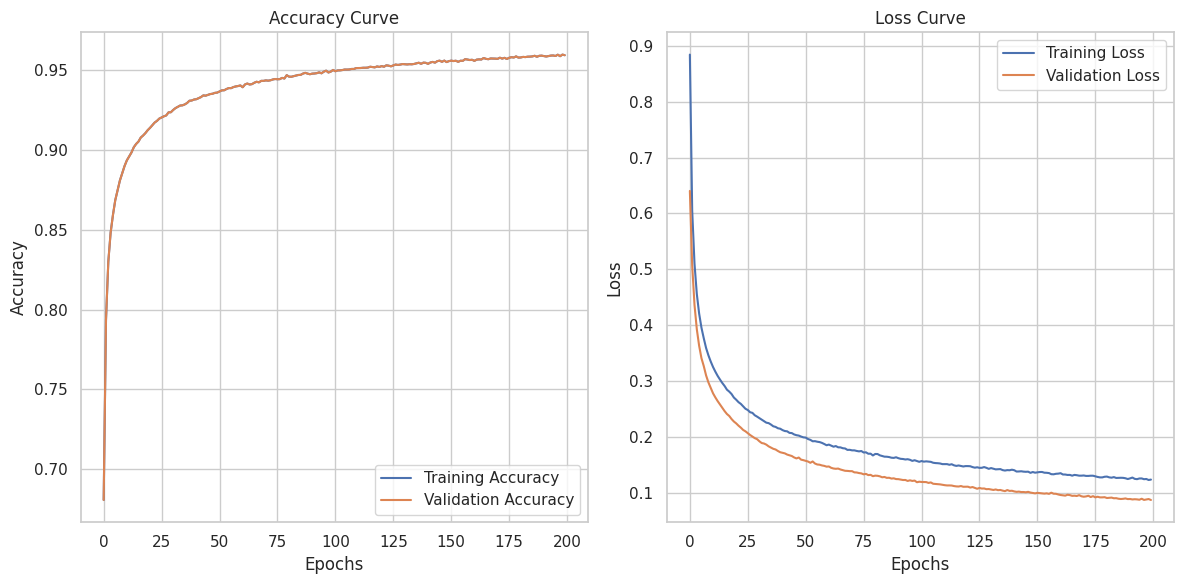

In [ ]:
show_learning_curves(history)

In [ ]:
predictions = np.argmax(model.predict(x_test), axis=1)
cm = create_confusion_matrix(y_test, predictions)

685/685 [==============================] - 3s 4ms/step
Confusion Matrix:
╒═════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╕
│         │   Class 0 │   Class 1 │   Class 2 │   Class 3 │   Class 4 │
╞═════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Class 0 │     17747 │       136 │       149 │        28 │        58 │
├─────────┼───────────┼───────────┼───────────┼───────────┼───────────┤
│ Class 1 │       139 │       401 │        13 │         1 │         2 │
├─────────┼───────────┼───────────┼───────────┼───────────┼───────────┤
│ Class 2 │        42 │         5 │      1379 │        19 │         3 │
├─────────┼───────────┼───────────┼───────────┼───────────┼───────────┤
│ Class 3 │        19 │         0 │        17 │       126 │         0 │
├─────────┼───────────┼───────────┼───────────┼───────────┼───────────┤
│ Class 4 │        18 │         4 │        10 │         1 │      1575 │
╘═════════╧═══════════╧═══════════╧═══════════╧═══════════╧════

In the provided analysis, we can observe the performance of our model for each individual class. The top table reveals that there is potential for enhancing the model's predictions in categories with a smaller number of samples. This indicates that further improvements can be made to increase the accuracy and precision in those specific classes.

In [ ]:
overall_metrics, class_metrics = metrics_calculation(y_test, predictions)

In [ ]:
print(overall_metrics)

{'precision': 0.9703428578538876, 'recall': 0.9696692855837749, 'f1': 0.9698796732742205}


In [ ]:
from prettytable import PrettyTable

# Create a table
table = PrettyTable()
table.field_names = list(class_metrics.keys())

# Find the maximum length of the arrays
max_length = max([len(arr) for arr in class_metrics.values()])

# Add rows to the table
for i in range(max_length):
    row = [f'{arr[i]:.3f}' if i < len(arr) else '-' for arr in class_metrics.values()]
    table.add_row(row)

# Print the table
print(table)

+-----------+--------+-------+
| precision | recall |   f1  |
+-----------+--------+-------+
|   0.988   | 0.980  | 0.984 |
|   0.734   | 0.721  | 0.728 |
|   0.879   | 0.952  | 0.914 |
|   0.720   | 0.778  | 0.748 |
|   0.962   | 0.979  | 0.970 |
+-----------+--------+-------+


Checking other metrics for each categories and the overal result. as indicated before, we are more interested in improving the recall as the cost associated with the false negative is higher.

<mark>(Optional) Testing holdout set</mark>

I have allocated 10% of the training dataset as a holdout set for testing purposes (it is different from validation or test set). To ensure a representative sample from each class, I applied the stratify technique during the split, considering the dataset's imbalanced nature. This approach helped me obtain an adequate number of samples from each class for reliable evaluation.

I introduced noise to the holdout set as an independent evaluation measure. The purpose of this noise addition was to simulate real-world scenarios and assess the model's robustness and generalization capabilities. 

It is important to note that the noise added to the holdout set was not utilized in the model training or data augmentation processes. Instead, it served as a means to evaluate the model's performance on data that includes additional variations beyond what was encountered during training. This allowed for a more comprehensive assessment of the model's ability to generalize and perform well in real-world scenarios where noise or other forms of variability may be present.

By incorporating similar variations utilized during training on the holdout set, the model's generalization would be better than when introducing new variations to the dataset.

However, we observe that the evaluation result over the holdout set is also giving us a good result which indicated a good generalization of the model.

In [9]:
model.evaluate(x_holdout, y_holdout, verbose=1)

274/274 [==============================] - 2s 6ms/step - loss: 0.1164 - accuracy: 0.9686


[0.11636000126600266, 0.9685929417610168]

In [ ]:
# model.save('/content/drive/MyDrive/modelECG.h5')